In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET 
import re
import hashlib
from skimage import transform

In [17]:
filenames = os.listdir("./")
dirs = [d for d in filenames if "-output" in d]
output_dir = "Masked/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

similar_dir = "Similar_Screenshot/"
if not os.path.exists(similar_dir):
    os.mkdir(similar_dir)

In [3]:
def mask_and_save_image(box):
    """
    This function take a mask range and mask the range with wite block and save image.
    
    Parameter:
    box : A four element list which note a rectangle range of image. 
          Example: (upper-left x, upper-left y, botton-right x, botton-y)
    """
    
    global count
    
    im = Image.open(dir_name + "/" + img_name)
    img_names = img_name.split('.')
    region=im.crop(box)

    mask = Image.new("RGBA",(box[2]-box[0],box[3]-box[1]),(255,255,255))

    im.paste(mask,box)
    im.save(save_dir +  img_names[0] + "-mask_" + str(count) + "-" + str(box) + "." + img_names[1])
    count += 1

In [4]:
# Find node recursively
def find_all_element_by_attribute(node, element_name, attribute, find):
    """
    This function use preorder traversal to find the all the XML objects by its attributs value.
    
    Parameters:
    node        : XML object.
    element_name: Target object name (name of node).
    attribute   : Target attribut name in XML object.
    find        : Target attribute value which mean to find.
    """
    if attribute in node.attrib and node.attrib[attribute] == find:
        # Operations after find the target XML objects.
        bounds = node.attrib['bounds']
        bounds = re.findall(r'(\w*[0-9]+)\w*',bounds)
        bounds = [int(i) for i in bounds]
        mask_and_save_image(bounds)
    
    # Visit all the target objects in current object.
    for n in node.findall(element_name):
        find_all_element_by_attribute(n, element_name, attribute, find)

In [5]:
def get_file_md5(f):
    m = hashlib.md5()
    while True:
        #如果不用二进制打开文件，则需要先编码
        data = f.readline()
        data = delete_attributes_by_name(data,["class"]).encode('utf-8')
        # data = f.read(1024)  #将文件分块读取
        if not data:
            break
        m.update(data)
        # print(data)
    return m.hexdigest()

In [6]:
def save_similar_screenshot(app_name1, im1, app_name2, im2):
    
    dir1 = os.path.join(app_name1, "stoat_fsm_output", "ui", im1)
    dir2 = os.path.join(app_name2, "stoat_fsm_output", "ui", im2)
    
    img1 = Image.open(dir1)
    img2 = Image.open(dir2)

    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(img1)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.gca().get_xaxis().set_ticks_position('none')
    plt.gca().get_yaxis().set_ticks_position('none')
    plt.xlabel("Visited")

    fig.add_subplot(1,2,2)
    plt.imshow(img2)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.gca().get_xaxis().set_ticks_position('none')
    plt.gca().get_yaxis().set_ticks_position('none')
    plt.xlabel("Duplicated")
    
    file_name = app_name1 + im1 + "-" + app_name2 + im2
    
    plt.savefig(similar_dir + file_name, dpi=300)
    plt.close()

In [14]:
def delete_attributes_by_name(object_string, keep_list):
    """
    This function takes an XML objects string (a line) and the attributes name which user want to keep. Then return 
    the cleaned XML objects string with only the attributs in keep list. And keep the XML object hierarchy.
    
    Parameters:
    object_string : And XML object string (a line in xml file).
    keep_list : An list of attributes name which want to keep.
    
    Return:
        The cleaned XML object string.
    """
    
    attributes = re.findall(r' [^<|^"|^\']*?=["|\']', object_string)
    # print(attributes)
    attributes = [re.findall(r'[^ |^=]+', x) for x in attributes]
    # print(attributes)
    attributes = [x for x in attributes if x[0] not in keep_list]
    
    for attr in attributes:
        sub_attr = " " + attr[0] + "=" + attr[1] + ".*?" + attr[1]
        object_string = re.sub(sub_attr, "", object_string)
    # print(object_string)
    return object_string

In [18]:
image_count = 0
for app_dir in dirs:
    app_name = app_dir.split("-")[0]
    dir_name = os.path.join(app_dir, "stoat_fsm_output", "ui")
    save_dir = output_dir + app_name + "/"
    if not os.path.exists(save_dir):
            os.mkdir(save_dir)
    
    files_names = os.listdir(dir_name)
    imgs = [d for d in files_names if "png" in d]
    
    visited_screenshot = []
    visited_screenshot_md5 = []
    
    for i in imgs:
        
        xml_name = [d for d in files_names if d == i.split(".")[0] + ".xml"]
        if len(xml_name) > 0:
            
            tree = ET.parse(dir_name + "/" + xml_name[0]) 
            root = tree.getroot()
            
            # Mask specific screen diretion image
            # '1' for only vertical, '0' for only horizon, '2' for both
            if root.attrib['rotation'] == '1':
                if root.attrib['rotation'] != '0' and root.attrib['rotation'] == '1':
                    print(app_name + i)
                continue
            
            # Check duplicate screenshot
            with open(dir_name + "/" + xml_name[0]) as f:
                file_md5 = get_file_md5(f)
                if file_md5 in visited_screenshot_md5:
                    duplicate_screenshot = [x for x in visited_screenshot if x[0] == file_md5]
                    if len(duplicate_screenshot) > 1:
                        print("Error: Have saved duplicate screenshot!")
                    save_similar_screenshot(duplicate_screenshot[0][1], duplicate_screenshot[0][2], app_dir, i)
                    continue
                else:
                    visited_screenshot.append((file_md5, app_dir, i))
                    visited_screenshot_md5.append(file_md5)
            
            # Start to mask screenshot
            count = 0
            img_name = i
            find_all_element_by_attribute(root, "node", "class", "android.widget.Button")
            
            # Save original image
            if count > 0:
                img = Image.open(dir_name + "/" + i)
                img.save(save_dir + i)
            
            image_count += 1
        elif len(xml_name) > 1:
            print(app_name, xml_name, "==============================================>")

print("Have masked " + str(image_count) + " screenshots!")

com.InteriorPhotoFramesnn_8S_1.png
com.InteriorPhotoFramesnn_8S_12.png
com.InteriorPhotoFramesnn_8S_13.png
com.InteriorPhotoFramesnn_8S_137.png
com.InteriorPhotoFramesnn_8S_156.png
com.InteriorPhotoFramesnn_8S_157.png
com.InteriorPhotoFramesnn_8S_161.png
com.InteriorPhotoFramesnn_8S_169.png
com.InteriorPhotoFramesnn_8S_203.png
com.InteriorPhotoFramesnn_8S_209.png
com.InteriorPhotoFramesnn_8S_212.png
com.InteriorPhotoFramesnn_8S_26.png
com.InteriorPhotoFramesnn_8S_295.png
com.InteriorPhotoFramesnn_8S_300.png
com.InteriorPhotoFramesnn_8S_330.png
com.InteriorPhotoFramesnn_8S_332.png
com.InteriorPhotoFramesnn_8S_336.png
com.InteriorPhotoFramesnn_8S_387.png
com.InteriorPhotoFramesnn_8S_388.png
com.InteriorPhotoFramesnn_8S_39.png
com.InteriorPhotoFramesnn_8S_45.png
com.InteriorPhotoFramesnn_8S_523.png
com.InteriorPhotoFramesnn_8S_6.png
com.InteriorPhotoFramesnn_8S_65.png
com.InteriorPhotoFramesnn_8S_7.png
com.InteriorPhotoFramesnn_8S_75.png
com.InteriorPhotoFramesnn_8S_8.png
com.InteriorPhot

======================================================================================================================
Below are test codes.

In [5]:
dir1 = "../Data/aib.ibank.android_84-output/stoat_fsm_output/ui/S_7.png"
im = Image.open(dir1)
im.save("test.png")
im1 = im.resize((160, 256), Image.ANTIALIAS)
im1.save("test1.png")
im2 = im.resize((320, 512), Image.ANTIALIAS)
im2.save("test2.png")

FileNotFoundError: [Errno 2] No such file or directory: 'Similar_Screenshot/aib.ibank.android_84-output/stoat_fsm_output/ui/S_3.png-aib.ibank.android_84-output/stoat_fsm_output/ui/S_7.png.png'

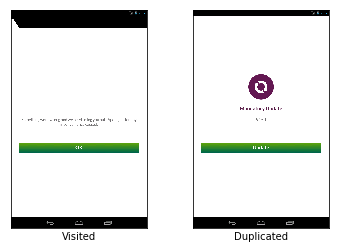

In [17]:
dir1 = "aib.ibank.android_84-output/stoat_fsm_output/ui/S_3.png"
dir2 = "aib.ibank.android_84-output/stoat_fsm_output/ui/S_7.png"

img1 = Image.open(dir1)
img2 = Image.open(dir2)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img1)
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.gca().get_xaxis().set_ticks_position('none')
plt.gca().get_yaxis().set_ticks_position('none')
plt.xlabel("Visited")

fig.add_subplot(1,2,2)
plt.imshow(img2)
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off')
plt.gca().get_xaxis().set_ticks_position('none')
plt.gca().get_yaxis().set_ticks_position('none')
plt.xlabel("Duplicated")

plt.savefig(similar_dir + dir1 + "-" + dir2 + ".png", dpi=300)

In [205]:
count = 0
find_all_element_by_attribute(root, "node", "class", "android.widget.Button")

In [35]:
dir_name = "./com.InteriorPhotoFramesnn_8-output/stoat_fsm_output/ui/"
tree = ET.parse(dir_name + "S_8.xml") 
root = tree.getroot()
str(root.attrib)

"{'rotation': '1'}"

In [12]:
diname = "./com.InteriorPhotoFramesnn_8-output/stoat_fsm_output/ui/"
im = Image.open(dirname + "S_692.png")
box = (666,1123,800,1216)
region=im.crop(box)
region.show()
mask = Image.new("RGBA",(box[2]-box[0],box[3]-box[1]),(255,255,255))
mask.show()
im.paste(mask,box)
im.show()

In [3]:
# def delete_attribtes_by_name(object_string, keep_list):
#     attributes_raw = object_string.split(" ")
#     attributes_keep = []
#     begin_delete = False
#     for attr in attributes_raw:
        
#         # Start to delete attributes when see a XML object start symbol ("<").
#         if "<" in attr and not begin_delete:
#             attributes_keep.append(attr)
#             begin_delete = True
#             continue
            
#         # Keep the blank before <node /> to keep the hierarchy structure
#         if not begin_delete:
#             attributes_keep.append(attr)
#             continue
        
#         if attr.split("=")[0] in keep_list:
#             attributes_keep.append(attr)
#         elif attributes_raw.index(attr) + 1 == len(attributes_raw):
#             attributes_keep.append(">")
#     return " ".join(attributes_keep)

In [6]:
dir_name = "./com.appsplan1.indianews_5-output/stoat_fsm_output/ui/"
with open(dir_name + "S_4.xml") as f1, open(dir_name + "S_3.xml") as f2:
    file1_md5 = get_file_md5(f1)
    file2_md5 = get_file_md5(f2)
    print('file1_md5:',file1_md5)
    print('file2_md5:',file2_md5)
    if file1_md5 != file2_md5:
        print('file has changed')
    else:
        print('file not changed')

file1_md5: 812a744f77462951851081c3a92ae18f
file2_md5: 812a744f77462951851081c3a92ae18f
file not changed


In [23]:
dir_name = "./ar.nbad.emobile.android.mobilebank_15277-output/stoat_fsm_output/ui/"
filenames = os.listdir(dir_name)
xmls = [d for d in filenames if "xml" in d]
for i1 in range(len(xmls)):
    for i2 in range(i1+1, len(xmls)):
        with open(dir_name + xmls[i1]) as f1, open(dir_name + xmls[i2]) as f2:
            file1_md5 = get_file_md5(f1)
            file2_md5 = get_file_md5(f2)
            # print('file1_md5:',file1_md5)
            # print('file2_md5:',file2_md5)
            if file1_md5 == file2_md5:
                print('file not changed', xmls[i1], xmls[i2])

In [138]:
dir_name = "./com.andromo.dev1847.app283467_31-output/stoat_fsm_output/ui/"
f = open(dir_name + "S_108.xml")
data = f.readline()
# data = f.readline()
# data = f.readline()
# data = f.readline()
# data = f.readline()
# data = f.readline()
# data = f.readline()
# data = f.readline()
data.encode('utf-8')
print(data)
# datas = re.findall(r' [^<]*?=', data)
# datas = [re.findall(r'[^ |^=]+', x) for x in datas]

# datas = [x[0] for x in datas if x[0] not in ["class", "index"]]
# print(datas)
print(delete_attributes_by_name(data,["class"]))
file1_md5 = get_file_md5(f)

<?xml version='1.0' encoding='UTF-8' standalone='yes' ?>

<?xml ?>

<?xml ?>

<hierarchy>

  <node class="android.widget.FrameLayout">

    <node class="android.widget.FrameLayout">

      <node class="android.widget.FrameLayout">

        <node class="android.widget.LinearLayout">

          <node class="android.widget.LinearLayout">

            <node class="android.widget.LinearLayout">

              <node class="android.widget.TextView" />

            </node>

            <node class="android.view.View" />

          </node>

          <node class="android.widget.LinearLayout">

            <node class="android.widget.ScrollView">

              <node class="android.widget.TextView" />

            </node>

          </node>

          <node class="android.widget.LinearLayout">

            <node class="android.widget.LinearLayout">

              <node class="android.widget.Button" />

            </node>

          </node>

        </node>

      </node>

    </node>

  </node>

In [62]:
dir_name = "./ar.nbad.emobile.android.mobilebank_15277-output/stoat_fsm_output/ui/"
f = open(dir_name + "S_196.xml")
content = f.read()
ss = " text"
st = ss + '=".*?"'
content = re.sub(r'content-desc=".*?"', " ", content)  #remove the filled text
content = re.sub(st, "", content)
print(content)

<?xml version='1.0' encoding='UTF-8' standalone='yes' ?>
<hierarchy rotation="0">
  <node index="0" resource-id="" class="android.widget.FrameLayout" package="ar.nbad.emobile.android.mobilebank"   checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrollable="false" long-clickable="false" password="false" selected="false" bounds="[0,0][800,1216]">
    <node index="0" resource-id="android:id/action_bar_overlay_layout" class="android.view.View" package="ar.nbad.emobile.android.mobilebank"   checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrollable="false" long-clickable="false" password="false" selected="false" bounds="[0,0][800,1216]">
      <node index="0" resource-id="android:id/top_action_bar" class="android.widget.LinearLayout" package="ar.nbad.emobile.android.mobilebank"   checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrolla